<a href="https://colab.research.google.com/github/eldor-fozilov/FracLSTM-Portfolio/blob/main/model_building_and_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import random

# Load the Data

In [2]:
selected_stocks = pd.read_csv("selected_stocks.csv", header = [0,1])
selected_stocks.head()

Unnamed: 0_level_0  Adj Close                                           \
  Unnamed: 0_level_1          A      AAPL       ABC       ABT       ADBE   
0               Date        NaN       NaN       NaN       NaN        NaN   
1         2000-01-03  43.929695  0.849469  2.980344  9.175173  16.274666   
2         2000-01-04  40.573959  0.777850  2.776868  8.913024  14.909400   
3         2000-01-05  38.057144  0.789232  2.992315  8.896641  15.204175   
4         2000-01-06  36.608093  0.720933  3.219730  9.207942  15.328290   

                                             ...     Volume             \
         ADI       ADM        ADP      ADSK  ...        WMB        WMT   
0        NaN       NaN        NaN       NaN  ...        NaN        NaN   
1  28.981533  6.548721  25.347609  8.052905  ...  2366796.0  8369900.0   
2  27.515394  6.480505  25.347609  7.660816  ...  3364720.0  6745100.0   
3  27.917074  6.378182  25.103891  7.178246  ...  2731730.0  7018700.0   
4  27.153872  6.412287  25.439016  6.740914  ...  8654732.0  6544500.0   

                                                                      \
          WY          X        XEL         XOM       XRAY        XRX   
0        NaN        NaN        NaN         NaN        NaN        NaN   
1   973700.0   494100.0  2738600.0  13458200.0   582300.0  3329164.0   
2  1201700.0  1202500.0   425200.0  14510800.0   317700.0  2361970.0   
3  1184600.0  1464500.0   500200.0  17485000.0  1188000.0  2375404.0   
4  1307700.0   675000.0   344100.0  19461600.0   534300.0  1650180.0   

                         
         YUM       ZION  
0        NaN        NaN  
1  3033493.0  1199600.0  
2  3315031.0   816100.0  
3  4642602.0  1124700.0  
4  3947658.0  1112100.0  

[5 rows x 627 columns]

In [3]:
selected_stocks.drop(0, axis = 0, inplace = True)
selected_stocks.set_index(selected_stocks.columns[0], inplace = True)
selected_stocks.index.name = 'Date'
selected_stocks.index = pd.to_datetime(selected_stocks.index)
selected_stocks

Adj Close                                                  \
                     A        AAPL         ABC         ABT        ADBE   
Date                                                                     
2000-01-03   43.929695    0.849469    2.980344    9.175173   16.274666   
2000-01-04   40.573959    0.777850    2.776868    8.913024   14.909400   
2000-01-05   38.057144    0.789232    2.992315    8.896641   15.204175   
2000-01-06   36.608093    0.720933    3.219730    9.207942   15.328290   
2000-01-07   39.658760    0.755083    3.638654    9.306244   16.072983   
...                ...         ...         ...         ...         ...   
2023-05-18  129.139999  175.050003  174.820007  108.470001  360.429993   
2023-05-19  128.869995  175.160004  173.389999  108.930000  371.250000   
2023-05-22  129.089996  174.199997  172.250000  108.250000  372.049988   
2023-05-23  128.639999  171.559998  171.259995  105.739998  370.420013   
2023-05-24  120.989998  171.839996  171.059998  104.040001  365.760010   

                                                                      ...  \
                   ADI        ADM         ADP        ADSK        AEE  ...   
Date                                                                  ...   
2000-01-03   28.981533   6.548721   25.347609    8.052905  11.028308  ...   
2000-01-04   27.515394   6.480505   25.347609    7.660816  11.028308  ...   
2000-01-05   27.917074   6.378182   25.103891    7.178246  11.454930  ...   
2000-01-06   27.153872   6.412287   25.439016    6.740914  11.412271  ...   
2000-01-07   27.917074   6.514612   26.017868    7.540173  11.582920  ...   
...                ...        ...         ...         ...        ...  ...   
2023-05-18  192.259995  72.790001  215.429993  204.839996  83.360001  ...   
2023-05-19  190.529999  73.230003  216.179993  200.889999  84.120003  ...   
2023-05-22  191.309998  73.440002  216.529999  203.490005  83.620003  ...   
2023-05-23  187.919998  75.050003  215.550003  196.639999  82.709999  ...   
2023-05-24  173.199997  72.849998  214.000000  196.750000  82.129997  ...   

               Volume                                               \
                  WMB         WMT         WY          X        XEL   
Date                                                                 
2000-01-03  2366796.0   8369900.0   973700.0   494100.0  2738600.0   
2000-01-04  3364720.0   6745100.0  1201700.0  1202500.0   425200.0   
2000-01-05  2731730.0   7018700.0  1184600.0  1464500.0   500200.0   
2000-01-06  8654732.0   6544500.0  1307700.0   675000.0   344100.0   
2000-01-07  2319625.0   7976900.0  1728000.0   904600.0   469500.0   
...               ...         ...        ...        ...        ...   
2023-05-18  6379400.0  15589500.0  4607200.0  5650900.0  2403900.0   
2023-05-19  5157200.0   9195600.0  3875500.0  5393500.0  2068500.0   
2023-05-22  5575800.0   5372600.0  2853600.0  4250100.0  1857400.0   
2023-05-23  5559400.0   5434100.0  3019900.0  5691400.0  3966300.0   
2023-05-24  5658900.0   6837900.0  4156400.0  7482300.0  3562000.0   

                                                                    
                   XOM       XRAY        XRX        YUM       ZION  
Date                                                                
2000-01-03  13458200.0   582300.0  3329164.0  3033493.0  1199600.0  
2000-01-04  14510800.0   317700.0  2361970.0  3315031.0   816100.0  
2000-01-05  17485000.0  1188000.0  2375404.0  4642602.0  1124700.0  
2000-01-06  19461600.0   534300.0  1650180.0  3947658.0  1112100.0  
2000-01-07  16603800.0  1401000.0  2366942.0  6063647.0   782000.0  
...                ...        ...        ...        ...        ...  
2023-05-18  12005600.0   938900.0   845000.0  1435400.0  9029700.0  
2023-05-19  13357700.0  1023900.0  1203300.0  1295400.0  7295900.0  
2023-05-22  12882000.0  2880800.0   915300.0  1644400.0  8414900.0  
2023-05-23  14394400.0  2093900.0  1218300.0  1828300.0  9434400.0  
2023-05-24  1633630

In [4]:
stock_returns = pd.read_csv("stock_returns.csv")
stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
stock_returns.set_index('Date', inplace = True)
stock_returns.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.079464,-0.088078,-0.070715,-0.028988,-0.087618,-0.051913,-0.010471,0.000000,-0.049914,0.000000,...,-0.022427,-0.038136,-0.038291,-0.038043,0.022765,-0.019340,0.000000,-0.047628,-0.020305,-0.049636
2000-01-05,-0.064038,0.014527,0.074724,-0.001840,0.019578,0.014493,-0.015915,-0.009662,-0.065064,0.037955,...,0.060018,-0.020620,0.051619,0.010152,0.037860,0.053082,0.017140,0.050209,0.005115,-0.001184
2000-01-06,-0.038819,-0.090514,0.073250,0.034393,0.008130,-0.027719,0.005333,0.013261,-0.062859,-0.003731,...,0.021134,0.010854,0.045717,0.006042,-0.009332,0.050405,0.001306,-0.020834,-0.008540,0.014118
2000-01-07,0.080043,0.046281,0.122316,0.010619,0.047440,0.027719,0.015832,0.022499,0.112050,0.014842,...,0.026268,0.072846,-0.033437,0.025770,0.000000,-0.002939,-0.002615,0.023408,-0.022551,0.002334
2000-01-10,0.058813,-0.017745,0.025975,-0.007067,0.037883,0.083468,0.000000,0.024292,-0.010151,-0.007394,...,-0.018693,-0.018417,-0.004369,-0.007858,0.000000,-0.014079,0.023287,-0.023408,0.039558,-0.018230


In [5]:
data_volume = pd.read_csv('data_volume.csv')[1:]
data_volume['Date'] = pd.to_datetime(data_volume['Date'])
data_volume.set_index('Date', inplace = True)
data_volume.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,4765083.0,512377600.0,944000.0,10734887.0,7813200.0,2533200.0,1088057.0,3141234.0,3348800.0,455600.0,...,3364720.0,6745100.0,1201700.0,1202500.0,425200.0,14510800.0,317700.0,2361970.0,3315031.0,816100.0
2000-01-05,5758642.0,778321600.0,810400.0,11722632.0,14927200.0,3228000.0,1087947.0,3008836.0,4297600.0,1293200.0,...,2731730.0,7018700.0,1184600.0,1464500.0,500200.0,17485000.0,1188000.0,2375404.0,4642602.0,1124700.0
2000-01-06,2534434.0,767972800.0,2695200.0,17479583.0,10221200.0,2601000.0,899971.0,2121771.0,3856800.0,320400.0,...,8654732.0,6544500.0,1307700.0,675000.0,344100.0,19461600.0,534300.0,1650180.0,3947658.0,1112100.0
2000-01-07,2819626.0,460734400.0,2543600.0,15756040.0,8253200.0,1890600.0,1186290.0,1892407.0,6387600.0,312700.0,...,2319625.0,7976900.0,1728000.0,904600.0,469500.0,16603800.0,1401000.0,2366942.0,6063647.0,782000.0
2000-01-10,2148446.0,505064000.0,2534400.0,10442172.0,10987200.0,2570000.0,1484516.0,1722181.0,1180800.0,483300.0,...,1683429.0,6714300.0,821900.0,704700.0,522000.0,8545400.0,613200.0,1913135.0,5531172.0,408800.0


In [6]:
data_frac_log_adj_close = pd.read_csv('data_frac_log_adj_close.csv')[1:]
data_frac_log_adj_close['Date'] = pd.to_datetime(data_frac_log_adj_close['Date'])
data_frac_log_adj_close.set_index('Date', inplace = True)
data_frac_log_adj_close.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,X,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.635831,-0.001063,0.120198,0.227643,0.229305,0.534337,0.354139,0.332249,0.248321,0.388635,...,0.501912,0.616515,0.662661,1.347921,0.267124,0.611663,2.047297,3.618651,0.174947,1.173799
2000-01-05,0.346612,0.024330,0.146044,0.136240,0.182214,0.347837,0.198837,0.173704,0.102517,0.259533,...,0.368342,0.356533,0.482288,0.983695,0.173802,0.428007,2.062241,3.667546,0.108718,0.798946
2000-01-06,0.250728,-0.025796,0.127443,0.128170,0.126186,0.218539,0.156834,0.140006,0.051920,0.163503,...,0.263867,0.280716,0.385891,0.800276,0.094384,0.337418,2.063381,3.647249,0.067176,0.638132
2000-01-07,0.303796,0.027274,0.156614,0.088687,0.137515,0.216505,0.136117,0.121833,0.176561,0.143691,...,0.222891,0.288195,0.259840,0.708364,0.078057,0.237704,2.061099,3.670054,0.038363,0.528288
2000-01-10,0.263876,0.000527,0.081223,0.058838,0.116749,0.244759,0.104773,0.107492,0.071313,0.103204,...,0.154302,0.175162,0.232873,0.608343,0.064233,0.185537,2.081451,3.647249,0.077489,0.438573


In [7]:
data_log_frac_order = pd.read_csv('data_log_frac_order.csv')
data_log_frac_order.set_index(data_log_frac_order.columns[0], inplace = True)
data_log_frac_order.index.name = 'Company'
data_log_frac_order

,Adj Close
Company,
A,0.812500
AAPL,0.937500
ABC,0.875000
ABT,0.890625
ADBE,0.890625
...,...
XOM,0.789062
XRAY,0.000000
XRX,0.000000


# Multivariate LSTM Model

In [8]:
def partition_dataset(seq_length, data):
    x = []
    y = []
    data_len = data.shape[0]

    for i in range(seq_length, data_len):
        _x = data[i-seq_length:i,[-2,-1]]
        _y = data[i, 0] # the first column is the target
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

In [9]:
def train_and_test_split(data, start_year, end_year, sequence_length):
  train_data = data[(data.index.year >= start_year) & (data.index.year <= end_year - 1)]
  test_data = pd.concat([train_data[-sequence_length:], data[data.index.year == end_year]], axis = 0)
  return train_data, test_data
  

In [10]:
def predict_returns(train_data, test_data, data_type, sequence_length, num_hidden_nodes):

  # Transform the data by standard scaling
  scaler = StandardScaler()
  
  if data_type == 'frac diff':
    features = train_data.iloc[:,[-2, -1]].values
    scaler.fit(features)
    train_data_scaled = pd.DataFrame(scaler.transform(features), index = train_data.index)
    test_data_scaled = scaler.transform(test_data.iloc[:,[-2,-1]].values)
    test_data_scaled = pd.DataFrame(test_data_scaled, index = test_data.index)

    train_data_scaled = pd.concat([train_data['Returns'], train_data_scaled], axis = 1).values
    test_data_scaled = pd.concat([test_data['Returns'], test_data_scaled], axis = 1).values
  
  else:
    scaler.fit(train_data.values)
    train_data_scaled = scaler.transform(train_data.values)
    test_data_scaled = scaler.transform(test_data.values)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = StandardScaler()
    scaler_pred.fit(train_data.iloc[:,0].values.reshape(-1, 1)) # the first column will always contain the variable we
    # want to predict (it can be returns or fractioanlly differentiated prices)

  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
  x_test, y_test = partition_dataset(sequence_length, test_data_scaled)

  # Model structure
  model = Sequential()
  n_neurons = num_hidden_nodes
  model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Training the model
  epochs = 100
  batch_size = 128
  early_stop = EarlyStopping(monitor='val_loss', patience=3)
  history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data = (x_test, y_test),
                    callbacks = [early_stop]
                   )
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  if data_type != 'frac diff':
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  else:
    y_pred = y_pred_scaled

  return y_pred

# Stock Universe Selection

In [11]:
drop_companies = data_log_frac_order['Adj Close'][data_log_frac_order['Adj Close'] == 0].index.values
drop_companies

array(['ATGE', 'DGX', 'DVA', 'HOG', 'IGT', 'JNPR', 'KSS', 'L', 'LH', 'OI',
       'PDCO', 'SRCL', 'VIAV', 'VTR', 'XRAY', 'XRX'], dtype=object)

In [12]:
subset_selected_stocks = stock_returns.drop(drop_companies, axis = 1)
subset_selected_stocks

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WHR,WM,WMB,WMT,WY,X,XEL,XOM,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.079464,-0.088078,-0.070715,-0.028988,-0.087618,-0.051913,-0.010471,0.000000,-0.049914,0.000000,...,-0.039181,-0.003604,-0.022427,-0.038136,-0.038291,-0.038043,0.022765,-0.019340,-0.020305,-0.049636
2000-01-05,-0.064038,0.014527,0.074724,-0.001840,0.019578,0.014493,-0.015915,-0.009662,-0.065064,0.037955,...,0.014614,0.003604,0.060018,-0.020620,0.051619,0.010152,0.037860,0.053082,0.005115,-0.001184
2000-01-06,-0.038819,-0.090514,0.073250,0.034393,0.008130,-0.027719,0.005333,0.013261,-0.062859,-0.003731,...,0.008256,-0.007221,0.021134,0.010854,0.045717,0.006042,-0.009332,0.050405,-0.008540,0.014118
2000-01-07,0.080043,0.046281,0.122316,0.010619,0.047440,0.027719,0.015832,0.022499,0.112050,0.014842,...,0.003079,-0.040671,0.026268,0.072846,-0.033437,0.025770,0.000000,-0.002939,-0.022551,0.002334
2000-01-10,0.058813,-0.017745,0.025975,-0.007067,0.037883,0.083468,0.000000,0.024292,-0.010151,-0.007394,...,0.012220,0.003766,-0.018693,-0.018417,-0.004369,-0.007858,0.000000,-0.014079,0.039558,-0.018230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-18,0.010665,0.013574,0.000172,-0.003221,0.010599,0.022619,-0.003566,0.006847,0.031642,0.000360,...,0.030849,-0.010370,0.008941,0.012891,0.001356,0.012253,-0.002577,0.009022,0.008924,0.040073
2023-05-19,-0.002093,0.000628,-0.008214,0.004232,0.029578,-0.009039,0.006027,0.003475,-0.019472,0.009076,...,-0.016750,0.002179,0.001027,-0.010352,0.002368,-0.015913,0.000910,0.004622,-0.001229,-0.017405
2023-05-22,0.001706,-0.005496,-0.006596,-0.006262,0.002153,0.004085,0.002864,0.001618,0.012859,-0.005962,...,0.000152,-0.006431,-0.000342,-0.008844,-0.009508,-0.005515,-0.000759,-0.012214,-0.024673,0.048132


In [13]:
random.seed(100)
subset_selected_tickers = list(subset_selected_stocks.columns)
subset_selected_tickers = random.sample(subset_selected_tickers, 30) # randomly choose 30 companies
subset_selected_tickers

['CVX',
 'ROP',
 'RHI',
 'ECL',
 'NVDA',
 'MMC',
 'PLD',
 'TER',
 'CL',
 'UNP',
 'CMS',
 'BIIB',
 'RL',
 'HRB',
 'AON',
 'EXPD',
 'MAS',
 'GHC',
 'KMB',
 'EFX',
 'CTSH',
 'EOG',
 'MDT',
 'MUR',
 'PAYX',
 'FCX',
 'ORCL',
 'ROST',
 'WEC',
 'INTC']

In [14]:
if 'AAPL' not in subset_selected_tickers:
  subset_selected_tickers[0] = 'AAPL'
if 'AMZN' not in subset_selected_tickers:
  subset_selected_tickers[-1] = 'AMZN'

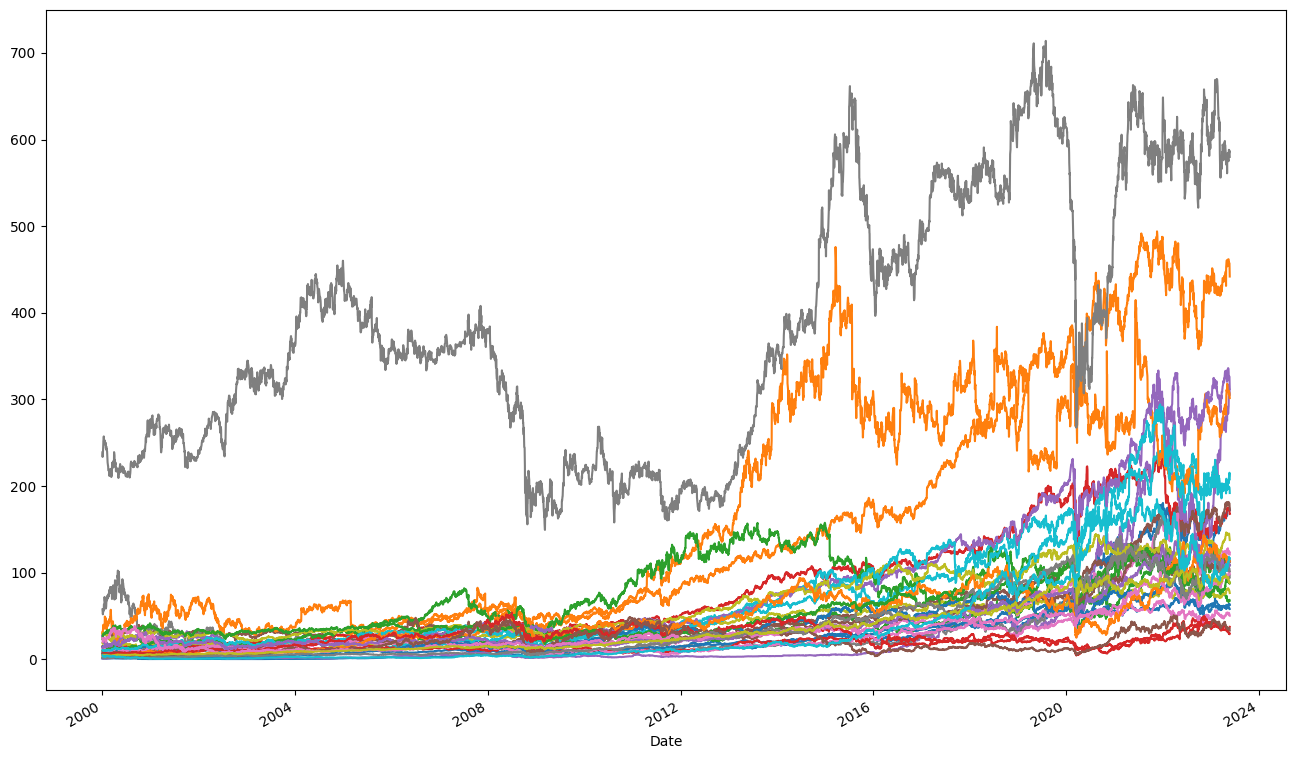

In [15]:
plt.figure(figsize = (16,10))
for comp in subset_selected_tickers:
  selected_stocks[('Adj Close', comp)].plot()

# Long / Short Portfolio Construction

In [16]:
def construct_portfolio(stock_universe_subset, stock_returns, frac_log_adj_close, volume,
                        start_year, end_year, training_period, train_data_type, seq_length, num_hidden_nodes):
  portfolio_returns_whole_test_period = pd.DataFrame()
  model_metrics = []
  for year in range(start_year, end_year - training_period + 1):
    print(f'ITERATION YEAR: {year}')
    return_predictions = {}
    model_metric = []
    for ticker in stock_universe_subset:
      
      if train_data_type == 'frac diff':
        stock = pd.concat([stock_returns[ticker], frac_log_adj_close[ticker], volume[ticker]], axis = 1)
        stock.columns = ['Returns','Frac Log Adj Close', 'Volume']
      else:
        stock = pd.concat([stock_returns[ticker], volume[ticker]], axis = 1)
        stock.columns = ['Returns', 'Volume']
      
      train_data, test_data = train_and_test_split(stock, year, year + training_period, sequence_length=seq_length)
      return_prediction = predict_returns(train_data, test_data, train_data_type, seq_length, num_hidden_nodes)
      return_predictions[ticker] = return_prediction.reshape(-1)
      
      model_metric.append(r2_score(stock_returns[ticker][stock_returns.index.year == (year + training_period)],
                                   return_prediction)) 
    model_metrics.append(model_metric)
    return_predictions = pd.DataFrame(return_predictions, index = test_data.index[seq_length:])
    
    portfolio_returns_for_one_year = {'High':[], 'Low': []}
    for index in return_predictions.index:
      one_day_returns = return_predictions.loc[index,:].sort_values(ascending = False)
      
      top_5_companies = one_day_returns.index[:5]
      bottom_5_companies = one_day_returns.index[-5:]
      top_5_returns = stock_returns.loc[index, top_5_companies]
      bottom_5_returns = stock_returns.loc[index, bottom_5_companies]
      
      long_portfolio_return = np.sum(top_5_returns) / 10
      short_portfolio_return = np.sum(bottom_5_returns) / 10
      
      portfolio_returns_for_one_year['High'].append(long_portfolio_return)
      portfolio_returns_for_one_year['Low'].append(short_portfolio_return)
    
    portfolio_returns_for_one_year = pd.DataFrame(portfolio_returns_for_one_year, index = return_predictions.index)
    portfolio_returns_whole_test_period = pd.concat([portfolio_returns_whole_test_period,
                                                    portfolio_returns_for_one_year], axis = 0)
  
  model_metrics = pd.DataFrame(model_metrics, columns = stock_universe_subset,
                                 index = range(start_year + training_period, end_year + 1))
  return portfolio_returns_whole_test_period, model_metrics

# Experiment 1 (21 lags)

In [ ]:
portfolio_returns_frac_diff, model_metrics_frac_diff = construct_portfolio(subset_selected_tickers, stock_returns,
                    data_frac_log_adj_close, data_volume, start_year=2000, end_year=2023,
                    training_period = 10, train_data_type = 'frac diff', seq_length=21, num_hidden_nodes = 7)

In [ ]:
portfolio_returns_frac_diff.to_csv('portfolio_returns_frac_diff.csv')

In [ ]:
model_metrics_frac_diff.to_csv('model_metrics_frac_diff.csv')

In [ ]:
portfolio_returns_frac_diff = pd.read_csv('portfolio_returns_frac_diff.csv')
portfolio_returns_frac_diff['Date'] = pd.to_datetime(portfolio_returns_frac_diff['Date'])
portfolio_returns_frac_diff.set_index('Date', inplace = True)
portfolio_returns_frac_diff

,High,Low
Date,,
2010-01-04,0.005203,0.003989
2010-01-05,0.002078,-0.000963
2010-01-06,-0.003630,-0.001953
2010-01-07,-0.000290,0.001739
2010-01-08,-0.001156,0.003798
...,...,...
2023-05-18,0.005492,0.003268
2023-05-19,-0.003176,0.000942
2023-05-22,-0.000691,-0.005717


<Axes: xlabel='Date'>

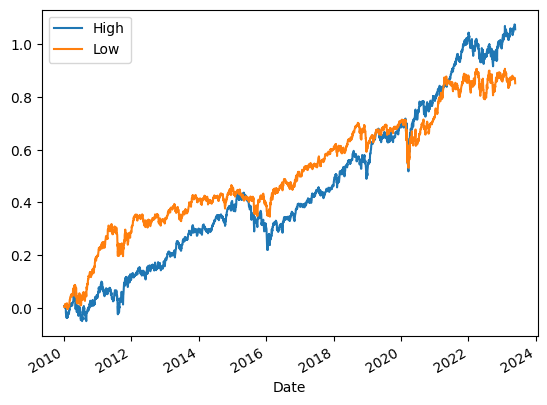

In [ ]:
portfolio_returns_frac_diff.cumsum().plot()

<Axes: xlabel='Date'>

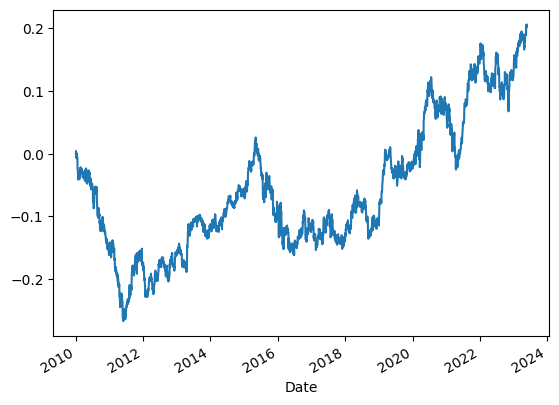

In [ ]:
long_short_returns = portfolio_returns_frac_diff['High'] - portfolio_returns_frac_diff['Low']
long_short_returns.cumsum().plot()

In [ ]:
model_metrics_frac_diff

,AAPL,ROP,RHI,ECL,NVDA,MMC,PLD,TER,CL,UNP,...,CTSH,EOG,MDT,MUR,PAYX,FCX,ORCL,ROST,WEC,AMZN
2010,-0.442756,-0.095448,-0.268380,-0.370392,-0.078746,-0.150856,-0.132860,-0.224906,-0.079781,-0.387861,...,-0.113560,-0.274169,-0.086582,-0.063589,-0.265850,-0.100314,-0.266557,-1.403518,-0.580047,-0.370792
2011,-1.662804,-0.062090,-0.086661,-0.743472,-0.290616,-0.112825,-1.224893,-0.075376,-0.997141,-0.184232,...,-0.050505,-0.100196,-0.141728,-0.036390,-0.229464,-0.097862,-0.186506,-0.222363,-0.349492,-0.030756
2012,-0.277162,-0.155008,-0.094815,-0.137687,-0.166703,-1.224556,-0.433426,-0.261120,-5.199316,-0.377664,...,-0.128498,-0.199995,-0.162339,-0.655061,-0.681622,-1.300330,-0.255236,-4.770958,-0.314898,-0.008833
2013,-0.164187,-0.438318,-0.358998,-2.403806,-0.670632,-2.063141,-0.377213,-0.099094,-1.302717,-0.105881,...,-0.322979,-1.400172,-0.434678,-1.401699,-4.241314,-0.280118,-0.620263,-0.798604,-0.657902,-0.181601
2014,-0.704433,-0.247973,-9.193245,-0.594930,-0.514671,-0.796259,-0.731003,-0.914527,-3.171130,-0.995837,...,-0.163147,-0.654064,-1.395997,-0.255341,-1.712465,-0.109790,-1.336393,-0.122976,-0.538074,-0.064586
2015,-0.314296,-1.901260,-0.615813,-0.112186,-0.022199,-0.192408,-0.169724,0.007011,-0.344673,-0.420349,...,-0.342660,-0.038110,-1.246897,-0.565054,-0.846388,-0.741274,-0.166757,-0.399775,-0.464919,-0.355489
2016,-1.146212,-0.687419,-0.281260,-0.215842,-0.437225,-0.561984,-1.638605,-1.714910,-0.326331,-0.466140,...,-0.495301,-0.075665,-21.027153,-0.052239,-0.582797,-0.170918,-0.110996,-0.227535,-0.657058,-0.119672
2017,-0.736888,-0.623691,-0.290833,-1.308344,-0.531237,-3.862645,-11.884151,-1.716851,-1.086558,-0.684921,...,-0.083728,-0.376429,-0.233515,-0.434606,-0.275973,-0.379730,-0.174807,-1.087498,-0.264533,-0.092975
2018,-0.399839,-0.421747,-1.186588,-0.565892,-0.222317,-0.846535,-0.724019,-0.452794,-0.535077,-0.260992,...,-0.058706,-0.432645,-0.162520,-0.563834,-0.691653,-0.151373,-0.174039,-0.818435,-0.080034,-1.005153
2019,-0.344251,-1.711524,-0.206245,-0.697197,-0.069230,-0.878896,-0.477757,-0.192350,-0.679591,-0.211228,...,-0.312852,-0.082308,-0.492861,-0.106740,-0.851406,-0.077725,-0.316422,-0.787048,-0.767485,-0.117736


# Benchmark Portfolio

In [ ]:
portfolio_returns_hist_ret, model_metrics_hist_ret = construct_portfolio(subset_selected_tickers, stock_returns,
                    data_frac_log_adj_close, data_volume, start_year=2000, end_year=2023,
                    training_period = 10, train_data_type = 'returns', seq_length=21)

In [ ]:
portfolio_returns_hist_ret.to_csv("portfolio_returns_hist_ret.csv")
model_metrics_hist_ret.to_csv('model_metrics_hist_ret.csv')

<Axes: xlabel='Date'>

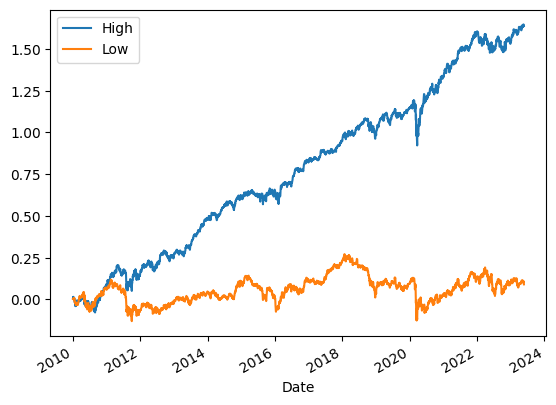

In [ ]:
portfolio_returns_hist_ret.cumsum().plot()

<Axes: xlabel='Date'>

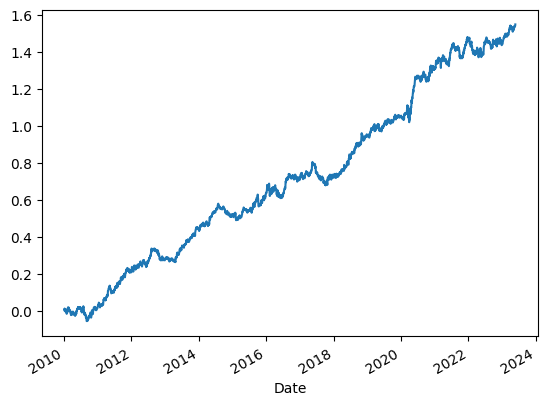

In [ ]:
long_short_returns_benchmark = portfolio_returns_hist_ret['High'] - portfolio_returns_hist_ret['Low']
long_short_returns_benchmark.cumsum().plot()

## Experiment 2 (4 lags)

In [ ]:
portfolio_returns_frac_diff_exp2, model_metrics_frac_diff_exp2 = construct_portfolio(subset_selected_tickers, stock_returns,
                    data_frac_log_adj_close, data_volume, start_year=2000, end_year=2023,
                    training_period = 10, train_data_type = 'frac diff', seq_length=4, num_hidden_nodes = 2)

Streaming output truncated to the last 5000 lines.
20/20 [==============================] - 0s 9ms/step - loss: 9.3468e-04 - val_loss: 0.0018
Epoch 82/100
20/20 [==============================] - 0s 9ms/step - loss: 9.1790e-04 - val_loss: 0.0018
Epoch 83/100
20/20 [==============================] - 0s 10ms/step - loss: 9.0323e-04 - val_loss: 0.0018
Epoch 84/100
20/20 [==============================] - 0s 10ms/step - loss: 8.8854e-04 - val_loss: 0.0018
Epoch 85/100
20/20 [==============================] - 0s 10ms/step - loss: 8.7381e-04 - val_loss: 0.0018
Epoch 86/100
20/20 [==============================] - 0s 10ms/step - loss: 8.6000e-04 - val_loss: 0.0017
Epoch 87/100
20/20 [==============================] - 0s 9ms/step - loss: 8.4691e-04 - val_loss: 0.0017
Epoch 88/100
20/20 [==============================] - 0s 10ms/step - loss: 8.3486e-04 - val_loss: 0.0017
Epoch 89/100
20/20 [==============================] - 0s 10ms/step - loss: 8.2173e-04 - val_loss: 0.0017
Epoch 90/100
20/20 [

In [ ]:
portfolio_returns_frac_diff_exp2.to_csv('portfolio_returns_frac_diff_exp2.csv')

In [ ]:
model_metrics_frac_diff_exp2.to_csv('model_metrics_frac_diff_exp2.csv')

In [ ]:
portfolio_returns_frac_diff_exp2 = pd.read_csv('portfolio_returns_frac_diff_exp2.csv')
portfolio_returns_frac_diff_exp2['Date'] = pd.to_datetime(portfolio_returns_frac_diff_exp2['Date'])
portfolio_returns_frac_diff_exp2.set_index('Date', inplace = True)
portfolio_returns_frac_diff_exp2

,High,Low
Date,,
2010-01-04,0.006319,0.002927
2010-01-05,0.001851,0.001363
2010-01-06,-0.003166,-0.002399
2010-01-07,-0.003728,-0.002749
2010-01-08,0.005420,0.000970
...,...,...
2023-05-18,0.005993,0.008028
2023-05-19,-0.001070,-0.001035
2023-05-22,0.001012,-0.002833


<Axes: xlabel='Date'>

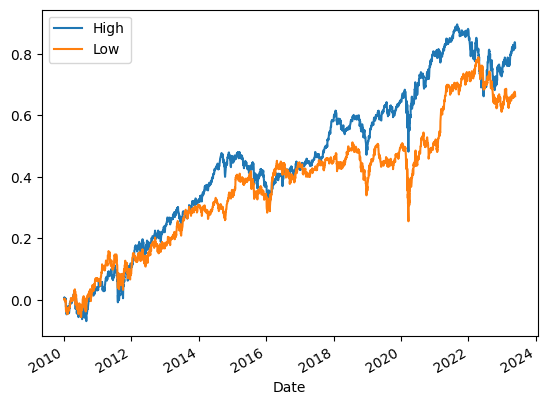

In [ ]:
portfolio_returns_frac_diff_exp2.cumsum().plot()

<Axes: xlabel='Date'>

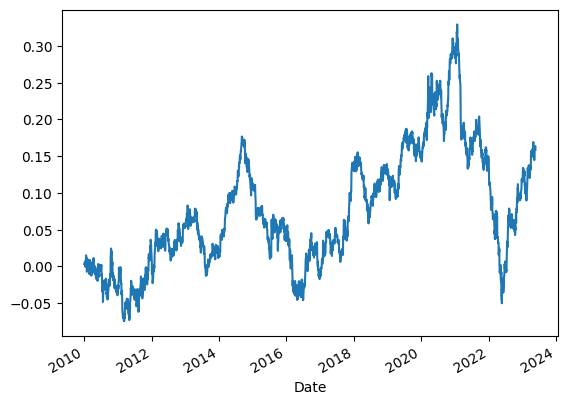

In [ ]:
long_short_returns_exp2 = portfolio_returns_frac_diff_exp2['High'] - portfolio_returns_frac_diff_exp2['Low']
long_short_returns_exp2.cumsum().plot()

In [ ]:
model_metrics_frac_diff_exp2

,AAPL,ROP,RHI,ECL,NVDA,MMC,PLD,TER,CL,UNP,...,CTSH,EOG,MDT,MUR,PAYX,FCX,ORCL,ROST,WEC,AMZN
2010,-1.514598,-0.035250,-0.043865,-0.172186,-0.043944,-0.028005,-0.241448,-0.106051,-0.760342,-0.018330,...,-0.270111,-0.029517,-0.130922,-0.064054,-0.022919,-0.087071,-0.019043,-0.240889,-0.101779,-0.109737
2011,-0.226504,-0.031848,-0.035238,-1.896691,-0.030098,-0.027018,-0.754089,-0.017554,-0.173275,-0.195248,...,-0.268851,-0.036680,-0.001097,-0.033314,-0.015517,-1.128581,-0.052431,-3.741050,-0.249807,-0.037067
2012,0.001889,-0.222392,-0.072713,-0.319588,-0.095102,-0.574599,-0.546929,-0.137287,-0.389573,-1.055475,...,-0.034805,-0.743825,-0.165453,-0.276703,-0.054791,-0.143174,-0.507186,-0.527025,-0.206963,-4.593312
2013,-0.099379,-0.048096,-0.492480,0.034896,-0.713000,-0.660156,-72.400640,-0.051390,-1.113409,-0.063981,...,-0.063942,-0.751584,-0.335563,-0.283758,-1.660578,-0.158605,-0.239811,-0.168763,-1.041540,-0.198948
2014,-0.203224,-0.345166,-0.689359,0.012104,-0.158204,-0.999855,-0.079908,-0.233535,-0.523457,-72.180226,...,-0.107347,-0.281801,-3.350693,-0.054586,-0.010267,-0.478461,-2.266621,-0.368084,-0.167702,-0.160390
2015,-0.208107,-0.015003,-3.753838,-0.050394,-0.054455,-0.152871,-0.313116,-0.195615,-1.208426,-0.046737,...,-1.310071,-0.064117,-0.797524,-0.682807,-1.344519,-0.008784,-0.036703,-0.370237,-0.033099,-0.104227
2016,-0.041026,-0.934493,-0.474015,-0.030806,-0.263764,-0.287798,-0.322773,-0.177862,-1.494272,-0.050101,...,-0.605095,-0.172599,-0.019965,-28.600255,-0.138106,-0.012943,-0.145537,-1.326074,-32.329595,-0.075785
2017,-0.046008,-1.958242,-0.615982,-0.852562,-0.050486,-0.430694,-0.853032,-0.096406,-0.203123,-0.020592,...,-0.055135,-0.284315,-1.040191,-0.052416,-0.843661,-0.344200,-0.215775,-0.067704,-0.579970,-0.050343
2018,-0.591132,-0.376525,-0.326899,-0.423753,0.013657,-0.811108,-0.593871,-0.085218,-0.088401,-0.018018,...,-0.115311,-0.114038,-0.027017,-0.107534,-0.868413,-0.004024,-0.007664,-0.410476,-1.785848,-0.082756
2019,-0.084713,-0.809781,-0.034191,-3.495819,-1.275008,-0.374088,-0.186489,-0.108473,-0.328412,-1.058021,...,-0.226636,-0.027832,-0.289568,-0.112876,-0.190511,-0.023134,-0.050686,-0.270251,-0.121483,-0.258834


# Benchmark Portfolio

In [17]:
portfolio_returns_hist_ret_exp2, model_metrics_hist_ret_exp2 = construct_portfolio(subset_selected_tickers, stock_returns,
                    data_frac_log_adj_close, data_volume, start_year=2000, end_year=2023,
                    training_period = 10, train_data_type = 'returns', seq_length=4, num_hidden_nodes = 2)

Streaming output truncated to the last 5000 lines.
Epoch 10/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0125 - val_loss: 0.8890
Epoch 11/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0113 - val_loss: 0.8887
Epoch 12/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0104 - val_loss: 0.8884
Epoch 13/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0095 - val_loss: 0.8881
Epoch 14/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0087 - val_loss: 0.8879
Epoch 15/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0082 - val_loss: 0.8878
Epoch 16/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0075 - val_loss: 0.8874
Epoch 17/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0069 - val_loss: 0.8872
Epoch 18/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0065 - val_loss: 0.8869
Epoch 19/100
20/20 [=======================

In [18]:
portfolio_returns_hist_ret_exp2.to_csv("portfolio_returns_hist_ret_exp2.csv")
model_metrics_hist_ret_exp2.to_csv('model_metrics_hist_ret_exp2.csv')

<Axes: xlabel='Date'>

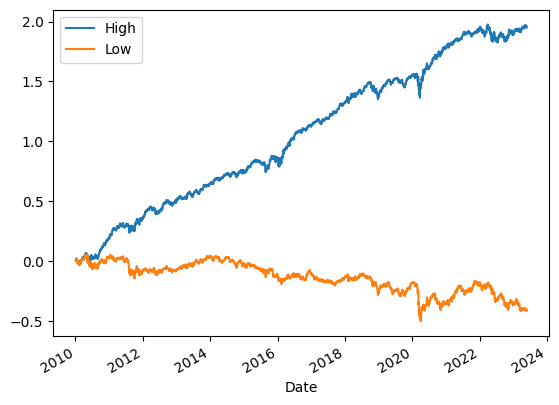

In [19]:
portfolio_returns_hist_ret_exp2.cumsum().plot()

<Axes: xlabel='Date'>

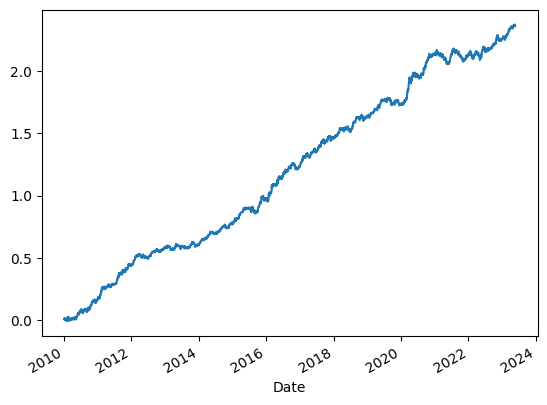

In [20]:
long_short_returns_benchmark_exp2 = portfolio_returns_hist_ret_exp2['High'] - portfolio_returns_hist_ret_exp2['Low']
long_short_returns_benchmark_exp2.cumsum().plot()